In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = int(np.sqrt(input_dim))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class Autoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z = fc(f3, self.n_z, scope='enc_fc4', activation_fn=tf.nn.relu)

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.recon_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss
        }
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z    

In [4]:
def trainer(model_object, learning_rate=1e-4, 
            batch_size=64, num_epoch=100, n_z=16, log_step=5):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and backward pass 
            # Report computed losses
            losses = model.run_single_step(batch[0])
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [ ]:
# Train a model
model = trainer(Autoencoder)

[Epoch 0] recon_loss: 164.636  (1.964 sec/epoch)
[Epoch 5] recon_loss: 108.206  (1.764 sec/epoch)
[Epoch 10] recon_loss: 95.195  (1.974 sec/epoch)
[Epoch 15] recon_loss: 88.714  (1.889 sec/epoch)
[Epoch 20] recon_loss: 91.857  (1.911 sec/epoch)
[Epoch 25] recon_loss: 86.745  (1.929 sec/epoch)
[Epoch 30] recon_loss: 86.889  (1.844 sec/epoch)
[Epoch 35] recon_loss: 80.609  (1.861 sec/epoch)
[Epoch 40] recon_loss: 82.426  (1.847 sec/epoch)
[Epoch 45] recon_loss: 83.165  (1.736 sec/epoch)
[Epoch 50] recon_loss: 78.575  (1.845 sec/epoch)
[Epoch 55] recon_loss: 77.812  (2.052 sec/epoch)
[Epoch 60] recon_loss: 76.335  (1.819 sec/epoch)
[Epoch 65] recon_loss: 78.208  (1.955 sec/epoch)
[Epoch 70] recon_loss: 81.920  (1.964 sec/epoch)
[Epoch 75] recon_loss: 81.874  (1.825 sec/epoch)
[Epoch 80] recon_loss: 76.830  (1.961 sec/epoch)
[Epoch 85] recon_loss: 87.618  (1.727 sec/epoch)
[Epoch 90] recon_loss: 74.598  (1.866 sec/epoch)
[Epoch 95] recon_loss: 74.243  (1.772 sec/epoch)
Done!


In [ ]:
def test_reconstruction(model, mnist, h=28, w=28, batch_size=100):
    # Test the trained model: reconstruction
    batch = mnist.test.next_batch(batch_size)
    x_reconstructed = model.reconstructor(batch[0])

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[0][i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

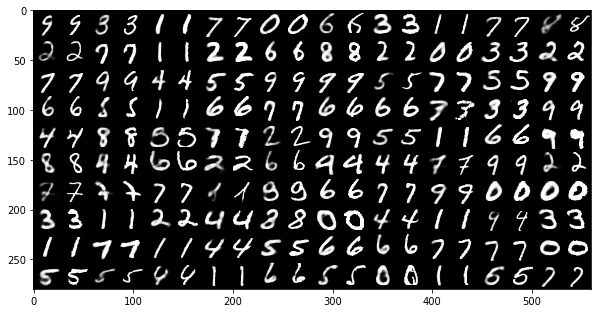

In [ ]:
test_reconstruction(model, mnist)

In [ ]:
# Train a model with 2d latent space
model_2d = trainer(Autoencoder, n_z=2)

[Epoch 0] recon_loss: 199.822  (1.909 sec/epoch)
[Epoch 5] recon_loss: 192.328  (1.898 sec/epoch)
[Epoch 10] recon_loss: 145.373  (1.766 sec/epoch)
[Epoch 15] recon_loss: 146.119  (1.940 sec/epoch)
[Epoch 20] recon_loss: 151.437  (1.948 sec/epoch)
[Epoch 25] recon_loss: 160.761  (1.760 sec/epoch)
[Epoch 30] recon_loss: 148.822  (1.844 sec/epoch)
[Epoch 35] recon_loss: 141.679  (1.833 sec/epoch)
[Epoch 40] recon_loss: 143.846  (2.037 sec/epoch)
[Epoch 45] recon_loss: 138.096  (1.711 sec/epoch)
[Epoch 50] recon_loss: 137.635  (1.773 sec/epoch)
[Epoch 55] recon_loss: 131.773  (1.922 sec/epoch)
[Epoch 60] recon_loss: 139.067  (2.102 sec/epoch)
[Epoch 65] recon_loss: 139.546  (1.906 sec/epoch)
[Epoch 70] recon_loss: 127.817  (1.850 sec/epoch)
[Epoch 75] recon_loss: 138.760  (1.856 sec/epoch)
[Epoch 80] recon_loss: 138.735  (1.794 sec/epoch)
[Epoch 85] recon_loss: 134.754  (1.884 sec/epoch)
[Epoch 90] recon_loss: 124.802  (1.823 sec/epoch)
[Epoch 95] recon_loss: 133.773  (2.085 sec/epoch)
Do

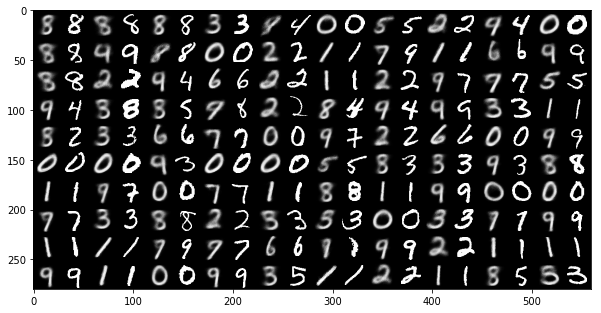

In [ ]:
test_reconstruction(model_2d, mnist)

In [ ]:
def test_transformation(model_2d, mnist, batch_size=3000):
    # Test the trained model: transformation
    assert model_2d.n_z == 2
    batch = mnist.test.next_batch(batch_size)
    z = model_2d.transformer(batch[0])
    plt.figure(figsize=(10, 8)) 
    plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1), s=20)
    plt.colorbar()
    plt.grid()

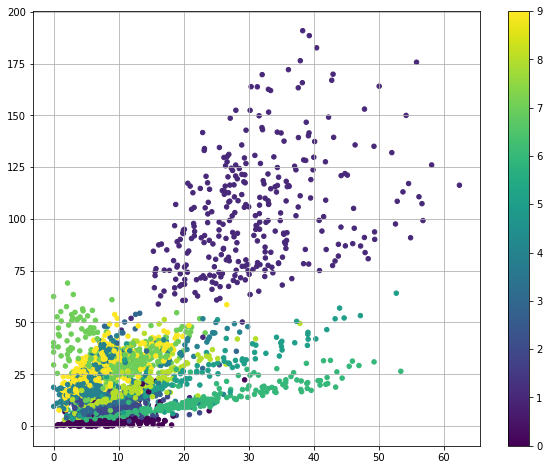

In [ ]:
test_transformation(model_2d, mnist)

In [ ]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [ ]:
# Train a model
model = trainer(VariantionalAutoencoder)

[Epoch 0] recon_loss: 190.490  latent_loss: 5.205  total_loss: 195.695  (2.348 sec/epoch)
[Epoch 5] recon_loss: 131.001  latent_loss: 14.424  total_loss: 145.424  (2.465 sec/epoch)
[Epoch 10] recon_loss: 116.262  latent_loss: 17.605  total_loss: 133.868  (2.463 sec/epoch)
[Epoch 15] recon_loss: 94.934  latent_loss: 18.148  total_loss: 113.082  (2.244 sec/epoch)
[Epoch 20] recon_loss: 94.612  latent_loss: 18.116  total_loss: 112.729  (2.532 sec/epoch)
[Epoch 25] recon_loss: 96.359  latent_loss: 19.385  total_loss: 115.744  (2.637 sec/epoch)
[Epoch 30] recon_loss: 91.643  latent_loss: 19.465  total_loss: 111.107  (2.236 sec/epoch)
[Epoch 35] recon_loss: 91.154  latent_loss: 19.811  total_loss: 110.965  (2.473 sec/epoch)
[Epoch 40] recon_loss: 90.285  latent_loss: 19.986  total_loss: 110.272  (2.296 sec/epoch)
[Epoch 45] recon_loss: 87.447  latent_loss: 19.963  total_loss: 107.410  (2.614 sec/epoch)
[Epoch 50] recon_loss: 88.429  latent_loss: 19.571  total_loss: 108.000  (2.356 sec/epoch)

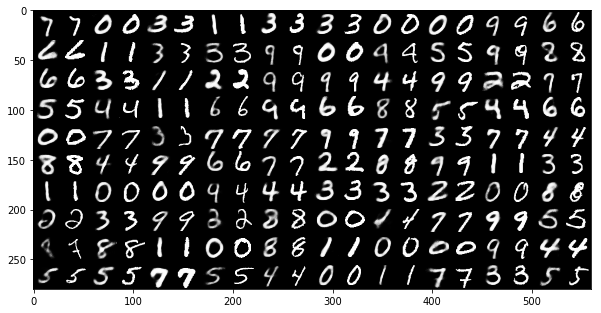

In [ ]:
test_reconstruction(model, mnist)

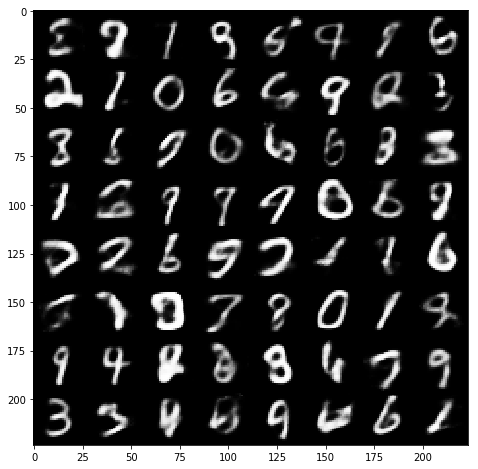

In [ ]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

In [ ]:
# Train a model with 2d latent space
model_2d = trainer(VariantionalAutoencoder, n_z=2)

[Epoch 0] recon_loss: 190.694  latent_loss: 4.371  total_loss: 195.066  (2.639 sec/epoch)
[Epoch 5] recon_loss: 166.146  latent_loss: 4.592  total_loss: 170.738  (2.500 sec/epoch)
[Epoch 10] recon_loss: 158.069  latent_loss: 5.256  total_loss: 163.325  (2.341 sec/epoch)
[Epoch 15] recon_loss: 149.287  latent_loss: 5.330  total_loss: 154.617  (2.532 sec/epoch)
[Epoch 20] recon_loss: 143.978  latent_loss: 5.783  total_loss: 149.760  (2.399 sec/epoch)
[Epoch 25] recon_loss: 134.043  latent_loss: 5.929  total_loss: 139.972  (2.601 sec/epoch)
[Epoch 30] recon_loss: 137.577  latent_loss: 5.793  total_loss: 143.370  (2.599 sec/epoch)
[Epoch 35] recon_loss: 134.183  latent_loss: 6.204  total_loss: 140.387  (2.368 sec/epoch)
[Epoch 40] recon_loss: 147.573  latent_loss: 6.086  total_loss: 153.659  (2.360 sec/epoch)
[Epoch 45] recon_loss: 129.339  latent_loss: 6.224  total_loss: 135.563  (2.518 sec/epoch)
[Epoch 50] recon_loss: 135.029  latent_loss: 6.251  total_loss: 141.280  (2.663 sec/epoch)
[

In [ ]:
test_transformation(model_2d, mnist)

In [ ]:
# Test the trained model: uniformly samlpe in the latent space
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generator(z)
        I_latent[(n-i-1)*h:(n-i)*h, j*w:(j+1)*w] = x_hat[0].reshape(h, w)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")